<a href="https://colab.research.google.com/github/VMBoehm/UndergradStudentProjects/blob/master/Jamie_and_Lister/VanessasNotebooks/PeakCounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# applying our methods to lensing convergence peak counts

In [0]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [0]:
! pip install numdifftools

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

datapath='./gdrive/My Drive/LFIwithMnus/data/'


### load the data

In [0]:
# load data (note that order of params is not the same as data_sim)
data_scaled        = np.load(datapath+'data_full_set_scaled.npy')
data_scaled_means   = np.load(datapath+'data_scaled_means.npy')
data_scaled_cosmos = np.load(datapath+'params_conc_old.npy')
data_scaled_cosmos_means = np.load(datapath+'params_conc_means.npy')

covariance = np.load(datapath+'covariance.npy')

In [7]:
data_scaled_cosmos.shape
data_scaled.shape

(101, 9999, 50)

In [8]:
# fiducial parameters (for compression)
index   = 51
theta_fiducial = data_scaled_cosmos[index]
print(theta_fiducial)
data    = data_scaled[index,0]


[0.1 0.3 2.1]


In [11]:
data.shape

(50,)

### Covariance Matrix

In [0]:
# compute covariance from covariance sims
Cinv = np.linalg.inv(covariance)

### Gaussian process interpolation of (precompressed) data

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on averages of full rescaled set
gp.fit(data_scaled_cosmos_means,data_scaled_means)

#use the GP prediction to build the model
def fwdmodel(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return np.squeeze(pred.T)

# compute derivative of mean at fiducial model with finite differencing


In [0]:
# set up scrore compression


def likelihood(data, params):
  mu  = fwdmodel(params)
  x   = data - mu
  logp= -0.5*np.dot(np.dot(x, Cinv),x)#+0.5*np.log(np.linalg.det(Cinv))-0.5*np.log(2*np.pi)
  return np.squeeze(logp)

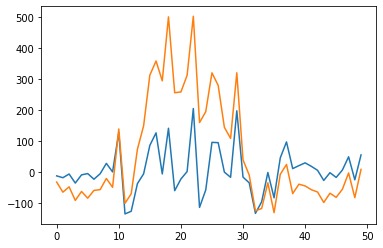

In [107]:
plt.plot(data-fwdmodel(theta_fiducial))
plt.plot(data-fwdmodel(theta_fiducial*1.01))

In [0]:
neglogpost = lambda x: -likelihood(data, x)

In [0]:
import numdifftools as nd

In [0]:
grad = nd.Gradient(neglogpost)

In [0]:
hess = nd.Hessian(neglogpost)

In [0]:
def derivative(params):
  delta_params=0.001*theta_fiducial
  deriv = np.zeros(len(params))
  for ii in range(len(params)):
    deltas = np.zeros(len(params))
    deltas[ii]+=delta_params[ii]
    deriv[ii] = (neglogpost(params+deltas)-neglogpost(params-deltas))/(2*delta_params[ii])
  return deriv

In [136]:
grad(theta_fiducial), derivative(theta_fiducial)

(array([-190.03950902, 3396.44212396,  375.23995954]),
 array([-190.03881232, 3395.94137023,  374.75877361]))

In [158]:
from scipy.optimize import minimize

log_posts = [] 
results = []
for theta_ini in np.sqrt(theta_fiducial)*np.random.randn(10,3)+theta_fiducial:
  print(theta_ini)
  for method in ['Powell']:#['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
    res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
    log_posts.append(neglogpost(res['x']))
    results.append(res['x'])

[ 0.29216898 -0.24259243  2.30772382]
Powell 0.03370247919753608
[-0.53346392  1.07019946  0.02602707]
Powell 33.94867904728181
[0.52270522 0.78504397 3.10765817]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.020701571927158696
[ 0.21653883  0.92299313 -0.10584775]
Powell 39.65814215672481
[ 0.0136755  -0.17375627  0.60340296]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.03377883583456115
[-0.43702737  0.0990827   1.62911691]
Powell 0.11326632832565463
[0.47143827 0.87576294 2.96016304]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.020664425873722105
[0.40136408 0.97320782 2.67746087]
Powell 0.16682321992694893
[-0.60274434  0.14132331  3.23786896]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.020735770540413923
[-0.0173851  -0.2678118   2.11251385]
Powell 0.0036251789026392994


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


In [0]:
index       = np.argsort((log_posts))
best_params = results[index[0]]

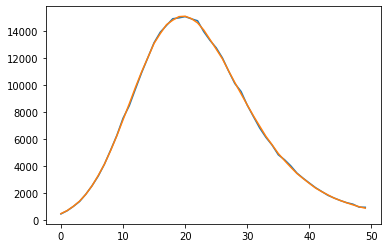

In [163]:
plt.plot(data)
plt.plot(fwdmodel(best_params))